# Martin Iniguez de Onzono. Programming AAND. Sheet 05.
# Spike-train decoding.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## a) Generate a Gaussian white-noise stimulus.

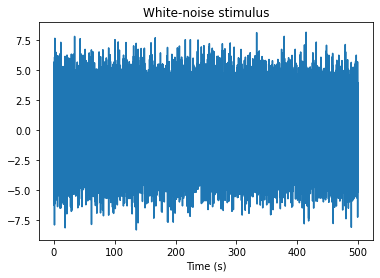

In [2]:
dt = 5e-3  # s
T = 500  # s
M = T/dt

var = 2  # s 
m_var = var/dt
mean = 0

t = np.arange(0,T,dt)

noise = np.random.normal(loc=0,scale=m_var,size=int(M))*dt

plt.plot(t,noise);
plt.title('White-noise stimulus')
plt.xlabel('Time (s)');

## b) Compute a firing rate r_est.

In [3]:
def enc_ker(tau, A=200,tau_cos=20e-3,sigma_cos=140e-3,sigma_exp=60e-3):
    cos_func = 2*np.pi*(tau-tau_cos)/sigma_cos
    D = -A*np.cos(cos_func)*np.exp(-tau/sigma_exp)
    return D

def est_fire(D,stim,r0):
    r_l = np.convolve(D,stim,'same')
    return (r0 + r_l)*dt

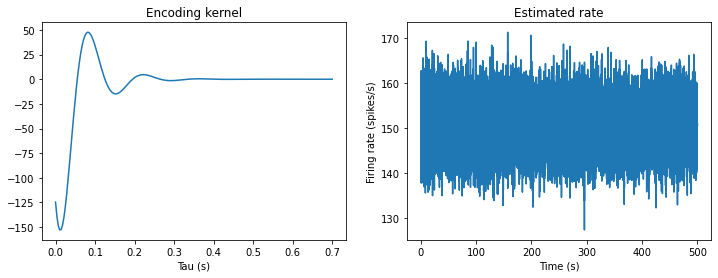

In [4]:
r0 = 150  # spikes/s
tau = np.linspace(0,0.7,200)
D = enc_ker(tau)

fig = plt.figure(figsize=(12,4))

fig.add_subplot(1,2,1)
            
plt.plot(tau,D)
plt.xlabel('Tau (s)')
plt.title('Encoding kernel')

fig.add_subplot(1,2,2)
r_est = r0 + est_fire(D,noise,r0)
plt.plot(t,r_est)
plt.xlabel('Time (s)')
plt.title('Estimated rate');
plt.ylabel('Firing rate (spikes/s)');

### c) Compute the autocorrelation.

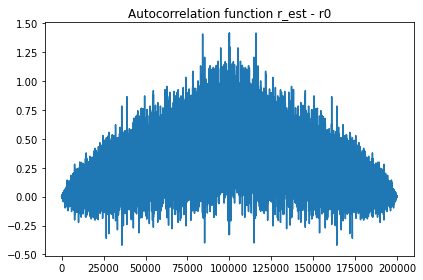

In [5]:
rest_corrected = r_est - r0
auto_corr = np.correlate(rest_corrected,rest_corrected,mode='full')*dt/T

no_mid_auto_corr = auto_corr.copy()

for i in range(0,50):
    no_mid_auto_corr[np.argmax(no_mid_auto_corr)] = 0
    no_mid_auto_corr[np.argmin(no_mid_auto_corr)] = 0

plt.plot(no_mid_auto_corr)
plt.title('Autocorrelation function r_est - r0')
plt.tight_layout()

### d) Generate a spike train from an inhomogeneous Poisson process.

In [6]:
def plot_spikes(spikes,t,t_stim):
    plt.eventplot(spikes)
    plt.ylim([0.4,1.6])
    plt.xlim([0,1]);
    plt.title('Raw spike data')
    plt.xlabel('Time (s)')
    plt.ylabel('Spikes')
    plt.yticks([])

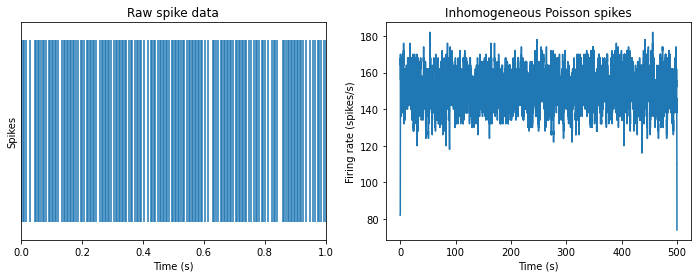

In [7]:
inhom = np.random.binomial(1,r_est*dt)
time_spikes = t[inhom==1]

fig = plt.figure(figsize=(12,4))

fig.add_subplot(1,2,1)
plot_spikes(time_spikes,t,T)

fig.add_subplot(1,2,2)
rect_wind = np.ones(np.int(0.5/dt))
rect = np.convolve(inhom,rect_wind,mode='same')/0.5
plt.plot(t,rect);
plt.title('Inhomogeneous Poisson spikes')
plt.xlabel('Time (s)');
plt.ylabel('Firing rate (spikes/s)');

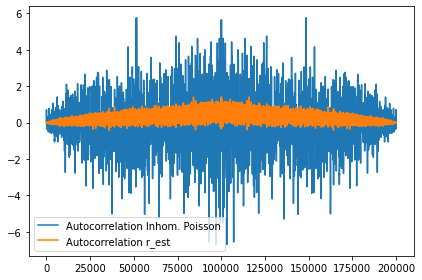

In [8]:
rect_center = rect - np.mean(rect)
inhom_corr = np.correlate(rect_center,rect_center,mode='full')*dt/T
no_mid_inhom_corr = inhom_corr.copy()

for i in range(0,185):
    no_mid_inhom_corr[np.argmax(no_mid_inhom_corr)]=0
    
plt.plot(no_mid_inhom_corr,label='Autocorrelation Inhom. Poisson');
plt.plot(no_mid_auto_corr,label='Autocorrelation r_est')
plt.tight_layout()
plt.legend();

The one corresponding to the Inhomogeneous Poisson process has a very random distribution and contains almost the same negative and positive values, making it a uncorrelated neural response.
On the case of the autocorrelation of the r_est, we can see it has a positive trend.

### e) Compute the autocorrelation of the encoding filter D.

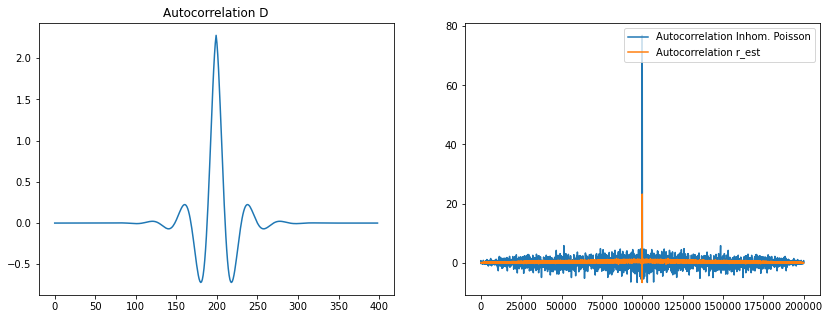

In [9]:
fig=plt.figure(figsize=(14,5))
fig.add_subplot(1,2,1)
D_corr = np.correlate(D,D,'full')*dt/T
plt.plot(D_corr,label='Encoding Kernel')
plt.title('Autocorrelation D');

fig.add_subplot(1,2,2)

plt.plot(inhom_corr,label='Autocorrelation Inhom. Poisson');
plt.plot(auto_corr,label='Autocorrelation r_est')
plt.legend();


#### What do you observe?

We can see that the autocorrelation of the encoding kernel D, as it could be expected, represents the form of a Gabor function (multiplication of an exponential and sinuosoidal functions). A lot of central peaks were needed to be taken out in order to visualize the functions in the previous exercises.

Also, the r_est autocorrelation has the minima lobes characteristic of the Gabor function.

### f) Compute a stimulus estimate.

[[ 1.         -0.00153172]
 [-0.00153172  1.        ]]
Seeing this correlation coefficients matrix, it can be seeing they are almost equal.


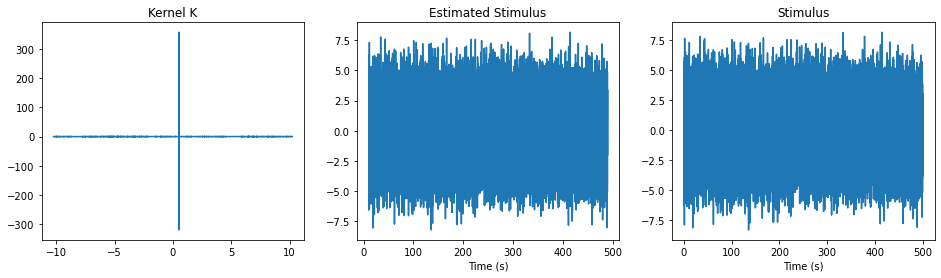

In [10]:
from estimate_decoder import estimate_decoder

k,k_time,s_est,s_est_time = estimate_decoder(t,noise,r_est,dt,nfft=2**12)

fig = plt.figure(figsize=(16,4))
fig.add_subplot(1,3,1)
plt.plot(k_time,k)
plt.title('Kernel K')

fig.add_subplot(1,3,2)
plt.plot(s_est_time,s_est,label='Estimated stimulus');
plt.xlabel('Time (s)')
plt.title('Estimated Stimulus');

fig.add_subplot(1,3,3)
plt.plot(t,noise,label='Stimulus')
plt.xlabel('Time (s)')
plt.title('Stimulus');

print(np.corrcoef(s_est,noise[0:len(s_est)]))
print('Seeing this correlation coefficients matrix, it can be seeing they are almost equal.')

#### g) Describe the realtion between the kernel D and decoding kernel K.

As K is 0 for all values of tau but tau0 = 0, we can say that we have a uncorrelated stimulus. (Dayan and Abott). However, that it is not what wanted to be introduced with the D kernel, whose apportation to the white noise is not as important as it could have been thought to be.